## Mechanistic Interpretability is hard
Mechanistic Interpretbaility(MI) is one of the approach to reverse engineer neural networks and understand what is happening inside these black-box models. Think of it as breaking up a car completly, and then understanding what each part contributes to.

MI has been quite successfull in understanding the inner working of complex neural networks like Transformers.

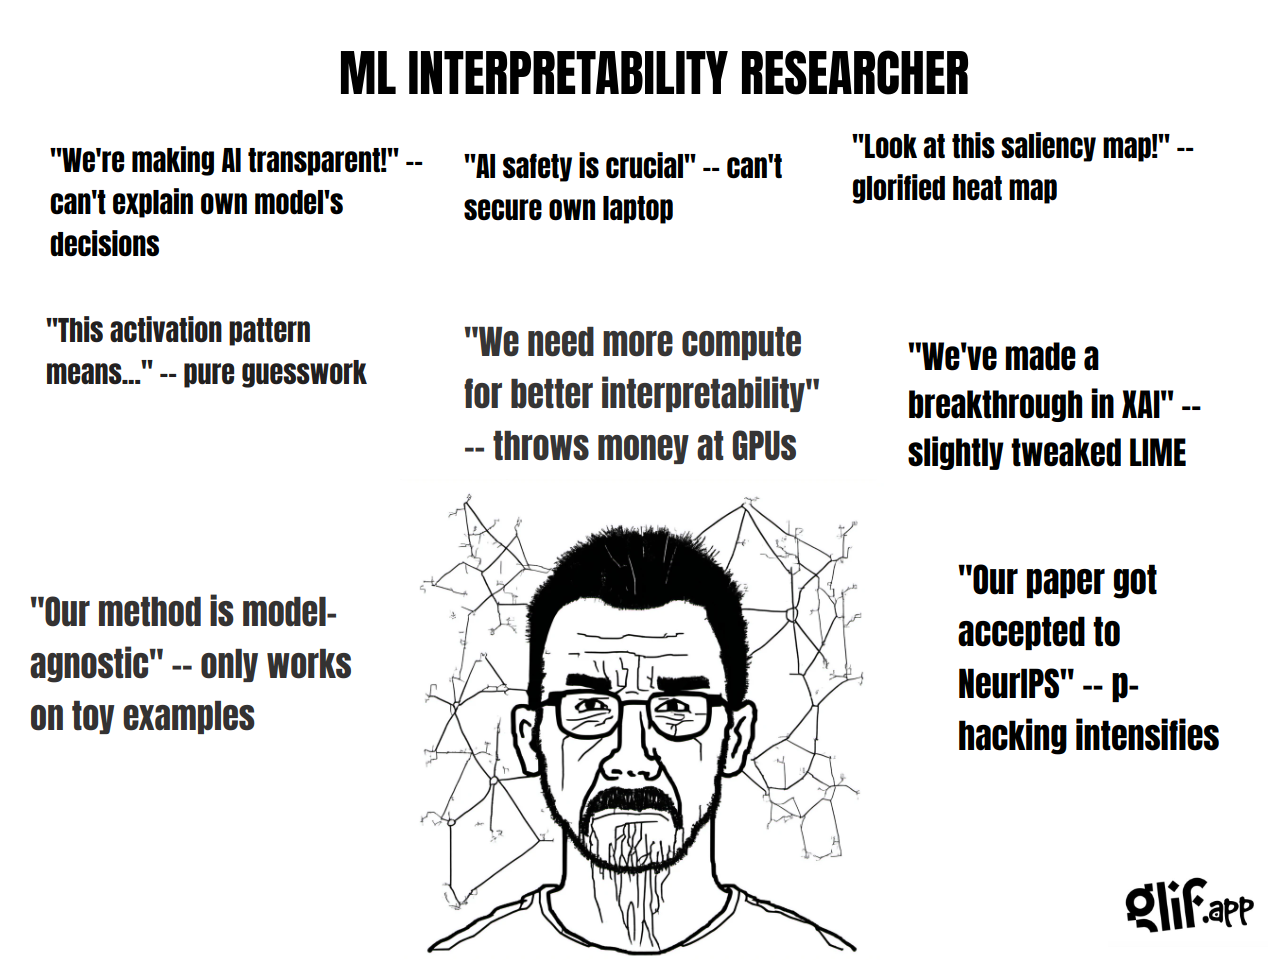

Well, it's really difficult to reverse engineer, and obviously, who likes to deal in unknowns. So, after a lot of reading and tinkering, I present **Arrakis**

## Why Arrakis?

Anthropic, the leader in MI have their own system called `Garcon` to interpret language models. In the open source, there is Neel Nanda's `Transformer Lens`. Arrakis aims to be somewhere it between. Arrakis offers a more comprehensive toolkit(beyond just activations) which greatly reduce time it takes to experiment. From someone who likes to move fast and break things, I want to ability to quickly iterate ideas and reduce experimentation time(and workload), and Arrakis captures that.

The core concept behind Arrakis is decomposibility. I've made it so that experimentation is flexible, and keeping track of experiments is a lot easier. Here are the main features.

- Ability to quickly experiment with plug-and-play tools.
- Ability to quickly log the experiment so you don't lose different versions.
- Ability to quickly graph without too much jargon.

Enough talk, let's dive in


## Activations? What are those?

The key idea behind MI is to "probe"(think of it as having hooks attached to each layer of the model) these big, complex neural networks, and see what happens in the forward pass of the model(forward pass is basically when an input is passed through each and every layer of the model). We store these, and it can be accessed very easily.

At it's core, this is what Arrakis does. We "hook" the model at each layer, and see what is the internal state of the model at that time(called `activations`), and try to find a mathematical explaination for it.

Like everything in Arrakis, I've made it in a plu and play fashion. Let's run some code! 

In [3]:
from pre_trained_models_hf import *

# Create the config. Just pass the name of the model, and additional parameters.
config = HookedAutoConfig("gpt2",  # other suppported models are : "gpt-neo","gpt-neox","llama","gemma","phi3","qwen2", "bloom", "mistral", "stable-lm"
        vocab_size=50256, 
        hidden_size=4, 
        intermediate_size=1, 
        num_hidden_layers=3, 
        num_attention_heads=4, 
        num_key_value_heads=2)

# Create the model. That's it!
## Note: The difference betweek a HookedAutoModel and a Huggingface model is just one line of plug-and play code.
model = HookedAutoModel(config)

# Create the ids(after the tokenization)
input_ids = torch.randint(0, 50256, (1, 50))  # Batch size 1, sequence length 50

# Forward pass - and you get activations and outputs!!
outputs, activations = model(input_ids)

activations.keys()

dict_keys(['wte', 'wpe', 'drop', 'blocks.0.hook_resid_pre', 'block.0.hook_resid_pre', 'h.0.ln_1', 'h.0.attn.c_attn', 'h.0.attn.attn_dropout', 'h.0.attn.c_proj', 'h.0.attn.resid_dropout', 'h.0.attn', 'blocks.0.attn.hook_result', 'blocks.0.attn.q', 'blocks.0.attn.k', 'blocks.0.attn.v', 'h.0.ln_2', 'h.0.mlp.c_fc', 'h.0.mlp.act', 'h.0.mlp.c_proj', 'h.0.mlp.dropout', 'h.0.mlp', 'blocks.0.mlp.hook_result', 'h.0', 'block.0.hook_resid_post', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'block.1.hook_resid_pre', 'h.1.ln_1', 'h.1.attn.c_attn', 'h.1.attn.attn_dropout', 'h.1.attn.c_proj', 'h.1.attn.resid_dropout', 'h.1.attn', 'blocks.1.attn.hook_result', 'blocks.1.attn.q', 'blocks.1.attn.k', 'blocks.1.attn.v', 'h.1.ln_2', 'h.1.mlp.c_fc', 'h.1.mlp.act', 'h.1.mlp.c_proj', 'h.1.mlp.dropout', 'h.1.mlp', 'blocks.1.mlp.hook_result', 'h.1', 'block.1.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'block.2.hook_resid_pre', 'h.2.ln_1', 'h.2.attn.c_attn', 'h.2.attn.attn_dr

## Well, that's OK. What can you do with those?

Once you hav activations, we can do any sort of analysis on the model.  We can add in functions to edit, remove or replace these activations as the model runs. The only limit is your imagination(also, math). But, what extra does Arrakis offers? I don't really like to beat around the bush, so let's look at some strengths of Arrakis.

### Feature 1: Experimentation
Time is a valuable resource, and especiallly for engineers, if you can reduce the time it takes to experiment, you are probably among the 1% of engineers.

Let's see what features does arrakis provides to experiment with ease.

In [4]:
from src.bench.base_bench import BaseInterpretabilityBench

# First, derive from the BaseBench class, and pass the model.
exp = BaseInterpretabilityBench(model)

# Step1: Create a function where you can do operations on the model.

@exp.log_experiment   # This is pretty much it. This will log the experiment.
def attention_experiment():
    print("This is a placeholder for the experiment. Use as is.")
    return 4

# Step 2: Then, you run the function, get results. This starts the experiment.
attention_experiment()

# Step 3: Then, we will look at some of the things that logs keep a track of
l = exp.list_versions("attention_experiment")  # This gives the hash of the content of the experiment.
print("This is the version hash of the experiment: ", l)

# Step 4: You can also get the content of the experiment from the saved json.
print(exp.get_version("attention_experiment", l[0])['source'])  # This gives the content of the experiment.

# Other than that, there are other decorator functions as well. Some of them are(a lot more features are coming soon!) :

# @exp.test_hypothesis - what if you want to test a hypothesis?
# @exp.profile_model - what if you want to see any performance bottlenecks ?
# exp.use_tools - well, let's see this in the next block :)

# Everything is decomposable. Don't want to use it? Just remove the decorator.

Running experiment: attention_experiment
This is a placeholder for the experiment. Use as is.
Results saved to experiments/attention_experiment.json
This is the version hash of the experiment:  ['9b00c29e']
@exp.log_experiment   # This is pretty much it. This will log the experiment.
def attention_experiment():
    print("This is a placeholder for the experiment. Use as is.")
    return 4



## You think that's cool? Watch this

As mentioned, decomposibility is at the core of Arrakis, and I've iterated over a lot of ideas to make things easier for people in the MI community. Every analysis you want to do in the model can be passed as a tool to the experiment bench itself. It's pretty cool, so let's look into it.

### Feature 2 : Tools
There are a lot of analysis you can do on the model activations, and there is no go-to way to use them, so I dug deep and made plug and play `tools` of most commonly used operations(from Anthropic, Eleuther) on models. In the spirit of decomposibility, just pass the name of the tool, and you are pretty much good to go.

Let's do some analysis on model activations. Everything is pretty easy in Arrakis.

In [5]:
# Making functions for Arrakis to use is pretty easy.Let's look it in action.

# Step 1: Create a function where you can do operations on the model. Think of all the tools you might need for it.
# Step 2: Use the @exp.use_tools decorator on it, with additional arg of the tool.
# Step 3: The extra argument gives you access to the function. Done.

@exp.use_tools("write_read")  # use the `exp.use_tools()` decorator.
def read_write_analysis(read_layer_idx, write_layer_idx, src_idx, write_read=None):  # pass an additional argument.
    # Multi-hop attention (write-read)

    # use the extra argument as a tool.
    write_heads = write_read.identify_write_heads(read_layer_idx)  
    read_heads = write_read.identify_read_heads(write_layer_idx, dim_idx=src_idx) 

    return {
        "write_heads": write_heads, 
        "read_heads": read_heads
    }

print(read_write_analysis(0, 1, 0)) # Perfecto!

{'write_heads': [(0, 3), (0, 1), (0, 2)], 'read_heads': [(1, 0), (1, 3), (1, 8), (1, 1), (1, 10), (1, 11), (1, 2), (1, 7), (1, 4)]}


In [6]:
# Let's look at another function in action.

@exp.use_tools("sparsity")  # use the `exp.use_tools()` decorator.
def sparsity_analysis(input_ids, key = "blocks.1.attn.hook_result", sparsity=None): # pass an additional argument.
    # Sparsity
    act_sparsity = sparsity.compute_activation_sparsity([input_ids], key)

    return {"activation_sparsity": act_sparsity}


print(sparsity_analysis(input_ids))  # Bingo.

{'activation_sparsity': 0.6799999999999999}


In [7]:
# Let's look at another function in action.

@exp.use_tools("superposition")  # use the `exp.use_tools()` decorator.
def superposition_analysis(input_ids, key = "blocks.1.attn.hook_result", superposition=None): # pass an additional argument.
    # Superposition
    act_covariance = superposition.compute_activation_covariance([input_ids], key)

    return {"activation_covariance": act_covariance}

print(superposition_analysis(input_ids))  # Bingo.

{'activation_covariance': tensor([[ 1.6319e-07, -9.0724e-08, -3.7205e-08,  ...,  8.6034e-09,
         -9.2423e-09,  1.2644e-09],
        [-9.0724e-08,  7.7681e-08,  1.1403e-08,  ..., -3.8596e-09,
          8.6758e-09, -1.0829e-09],
        [-3.7205e-08,  1.1403e-08,  1.1643e-08,  ..., -2.2760e-09,
          9.0206e-10, -1.5885e-10],
        ...,
        [ 8.6034e-09, -3.8596e-09, -2.2760e-09,  ...,  4.8487e-10,
         -3.6736e-10,  5.3784e-11],
        [-9.2423e-09,  8.6758e-09,  9.0206e-10,  ..., -3.6736e-10,
          9.8280e-10, -1.2094e-10],
        [ 1.2644e-09, -1.0829e-09, -1.5885e-10,  ...,  5.3784e-11,
         -1.2094e-10,  1.5095e-11]])}


### Isn't that a bit redundant?
Lol yes, so just use them all at once :)

In [8]:
# Honestly, we can just do it in a single funcction lol. PLus log the experiment as well :)

@exp.log_experiment
@exp.use_tools("write_read", "sparsity", "superposition")
def analyze_all(input_ids, src_idx, write_read=None, sparsity=None, superposition=None):
    
    # Multi-hop attention (write-read)
    write_heads = write_read.identify_write_heads(0)  # Example layer
    read_heads = write_read.identify_read_heads(1, dim_idx=src_idx)  # Example layer

    # Sparsity
    act_sparsity = sparsity.compute_activation_sparsity([input_ids], "blocks.1.attn.hook_result")

    # Superposition
    act_covariance = superposition.compute_activation_covariance([input_ids], "blocks.1.attn.hook_result")
    
    return {"write_heads": write_heads, 
            "read_heads": read_heads,
            "activation_sparsity": act_sparsity,
            "activation_covariance": act_covariance
    }

analyze_all(input_ids, 0)

# Although I'm pretty biased, but that is COOL.

Running experiment: analyze_all
Results saved to experiments/analyze_all.json


{'write_heads': [(0, 3), (0, 1), (0, 2)],
 'read_heads': [(1, 0),
  (1, 3),
  (1, 8),
  (1, 1),
  (1, 10),
  (1, 11),
  (1, 2),
  (1, 7),
  (1, 4)],
 'activation_sparsity': 0.5700000000000001,
 'activation_covariance': tensor([[ 1.9843e-07, -1.5161e-07, -3.6193e-08,  ..., -1.2157e-08,
          -1.7133e-09,  3.5135e-09],
         [-1.5161e-07,  1.7487e-07,  3.0395e-08,  ..., -5.9086e-10,
          -6.1060e-09, -2.5271e-10],
         [-3.6193e-08,  3.0395e-08,  6.7287e-09,  ...,  1.7585e-09,
          -3.1925e-11, -5.2789e-10],
         ...,
         [-1.2157e-08, -5.9086e-10,  1.7585e-09,  ...,  2.3984e-09,
           1.3460e-09, -6.2227e-10],
         [-1.7133e-09, -6.1060e-09, -3.1925e-11,  ...,  1.3460e-09,
           9.4626e-10, -3.3581e-10],
         [ 3.5135e-09, -2.5271e-10, -5.2789e-10,  ..., -6.2227e-10,
          -3.3581e-10,  1.6239e-10]])}

## Can we go sicko mode?
There's one more cool thing I want to show that Arrakis does by default. Graphing is at the core of any MI experiment, and the ability to plot graphs and draw conclusions is pretty dope imo.

### Feature 3 : Graphing
If you have noticed a pattern, even the graphing library(trying my best to replicate the `CircuitsVis` library by Alan Cooney) is a plug and play tool. Let's look at the code to generate attention heatmap of a particular activation by literally doing - nothing :)

[<Figure size 640x480 with 2 Axes>]

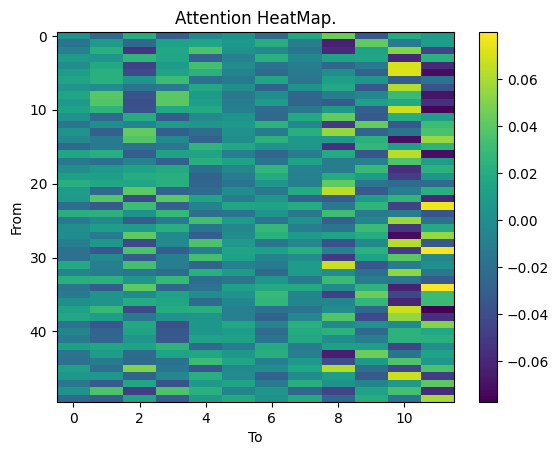

In [9]:
# Graphing plots is really easy in Arrakis. Let's see how it's done.

from src.graph.base_graph import *

# Step 1: Create a function where you can want to draw plot.
# Step2: Use the @exp.plot_results decorator on it(set the plotting lib), with additional arg of the plot spec. Pass input_ids here as well(have to think on this)
# Step3: The extra argument gives you access to the fig. Done.

exp.set_plotting_lib(MatplotlibWrapper) # Set the plotting library.

@exp.plot_results(PlotSpec(plot_type = "attention", data_keys = "h.1.attn.c_attn"), input_ids=input_ids) # use the `exp.plot_results()` decorator.
def attention_heatmap(fig=None): # pass an additional argument.
    return fig

attention_heatmap() # Done.

### What more is there to be done?

A LOT. I mean a lot. I'm working on making sure everything works as intended and loss is minimal. I am making progress, and I think I am going at good place. The good thing though is that it is really good to get this out in the world. It's not in my head anymore. There's only one way to move forward, and that is : "Move fast and Break Things".

#### Things that are pending
- Adding support for more models, without breaking the core library.
- Pypi support + making a package out of it
- Writing and doing a lot of tests.
- Writing good docs.
- CLI tool.

Plus a lot of making sure that my progress doesn't clmap to 0 :)

Thanks buildspace for s5. I would love some feedback.

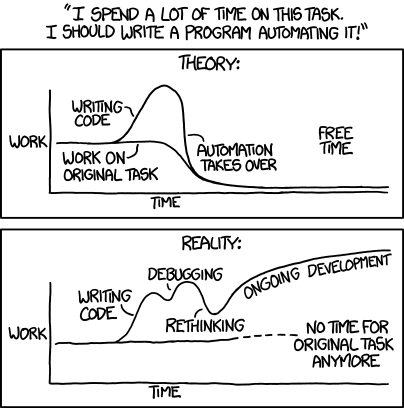


